In [6]:

from dataset import MonkeyMazeDataset, my_transforms
from memory_profiler import profile
from torch.utils.data import DataLoader, random_split
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from dataset import MonkeyMazeDataset, my_transforms as transforms
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
import sklearn 
from sklearn import metrics
import logging
from scipy import signal
import matplotlib.pyplot as plt
from sklearn import preprocessing
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import random_split

import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms import ToPILImage
import torch.nn as nn
import torchvision.models as models

from torchvision.transforms.functional import to_tensor

from torch import nn, optim



import torch.nn.functional as F
import random 


import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms.functional as TF
from torch import nn, optim
from torchvision.transforms import ToPILImage, Resize, ToTensor, Lambda

ModuleNotFoundError: No module named 'memory_profiler'

sample matche pairs:
('/Users/xinglanzhao/Desktop/monkeymaze/MazeImage/Hermann_20210216T144020_detour_nodes_trial_101.png', [4, 5, 4, 4], 1)
('/Users/xinglanzhao/Desktop/monkeymaze/MazeImage/Hermann_20210216T144020_detour_nodes_trial_101.png', [4, 4, 3, 4], 0)
('/Users/xinglanzhao/Desktop/monkeymaze/MazeImage/Hermann_20210216T144020_detour_nodes_trial_101.png', [3, 4, 3, 3], 0)
('/Users/xinglanzhao/Desktop/monkeymaze/MazeImage/Hermann_20210216T144020_detour_nodes_trial_101.png', [3, 3, 3, 2], 0)
('/Users/xinglanzhao/Desktop/monkeymaze/MazeImage/Hermann_20210216T144020_detour_nodes_trial_102.png', [5, 5, 5, 4], 0)
 Found 398068 image-feature-label pairs.
Sample 0 - Features: tensor([4., 5., 4., 4.]), One-hot label: 1
Sample 1 - Features: tensor([4., 4., 3., 4.]), One-hot label: 0
Sample 2 - Features: tensor([3., 4., 3., 3.]), One-hot label: 0
Sample 3 - Features: tensor([3., 3., 3., 2.]), One-hot label: 0
Sample 4 - Features: tensor([5., 5., 5., 4.]), One-hot label: 0


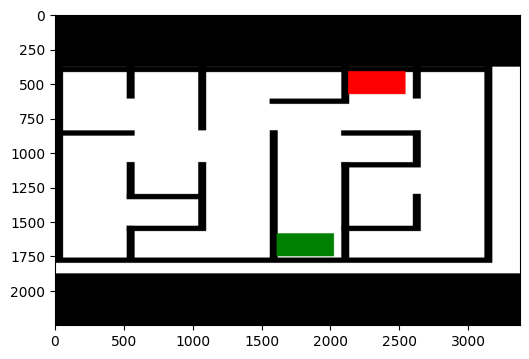

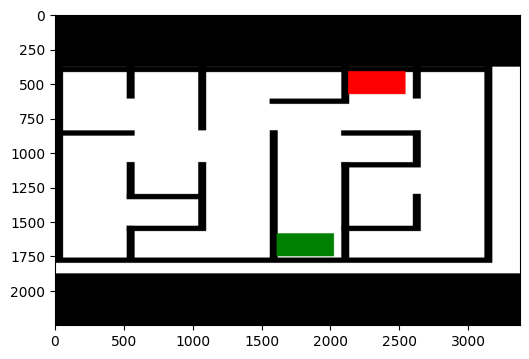

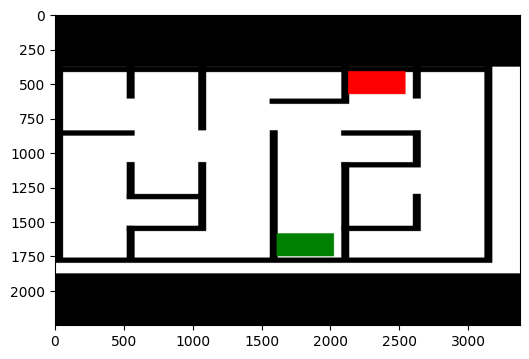

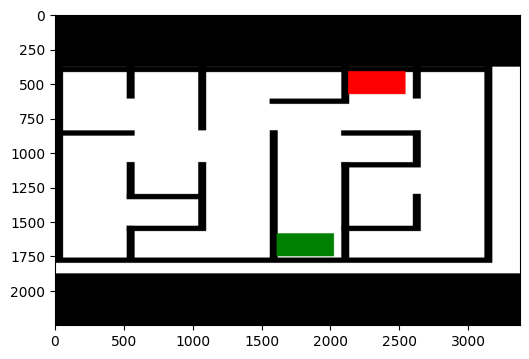

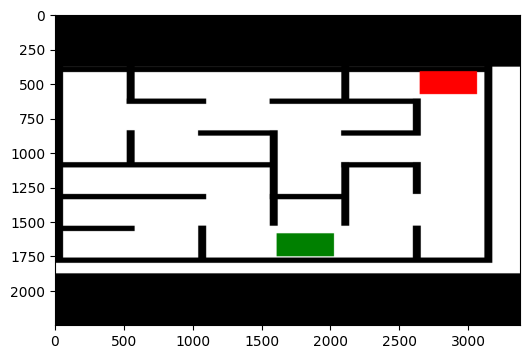

In [15]:

# Define your image and trajectory directories

image_dir = '/Users/xinglanzhao/Desktop/monkeymaze/MazeImage'
trajectory_dir = '/Users/xinglanzhao/Desktop/monkeymaze/Monkeytrajectory'





# file_to_label = process_directory(trajectory_dir)

# # Optionally define transforms
# transforms = ToTensor()  # Example transform that converts images to PyTorch tensors



# dataset = MonkeyMazeDataset(image_dir=image_dir, trajectory_dir=trajectory_dir,labels=file_to_label, transform=transforms
dataset = MonkeyMazeDataset(image_dir=image_dir, trajectory_dir=trajectory_dir,transform=transforms)






 # Debug Manually access a few items from the dataset
for idx in range(5):  # Adjust this range as needed
    
    image, features_tensor, label_one_hot = dataset[idx]
    print(f"Sample {idx} - Features: {features_tensor}, One-hot label: {label_one_hot}")

    image = ToPILImage()(image)
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    

In [18]:
def set_seed(seed):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)



class Config:
    batch_size = 32
    lr = 0.0001 
    epochs =5 # num epochs 




In [ ]:


# Define the custom model class customalexnet Load the pre-trained AlexNet model
import torch.nn as nn
import torchvision.models as models
from torchvision.models import alexnet, AlexNet_Weights


# model = torchvision.models.alexnet(pretrained=True)
# print(model)

# # modify the last classifer（classifier‘s 6th layer），
# model.classifier[6] = nn.Linear(in_features=model.classifier[6].in_features, out_features=4)


class CustomAlexNet(nn.Module):
    def __init__(self, num_traj_features, num_classes):
        super(CustomAlexNet, self).__init__()
        # Define the convolutional layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        
          # Redefining the classifier
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(256 * 6 * 6 + num_traj_features, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        
    def forward(self, images, traj_features):
        x = self.features(images)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        # Combine image features with trajectory features
        combined_features = torch.cat((x, traj_features), dim=1)
        output = self.classifier(combined_features)

        return output





        



        





    
        
    

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /Users/xinglanzhao/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:14<00:00, 16.7MB/s] 


In [20]:
def get_logger(filename, verbosity=1, name=None):
    level_dict = {0: logging.DEBUG, 1: logging.INFO, 2: logging.WARNING}
    formatter = logging.Formatter(
        "[%(asctime)s]%(message)s"
    )
    logger = logging.getLogger(name)
    logger.setLevel(level_dict[verbosity])

    fh = logging.FileHandler(filename, "w")
    fh.setFormatter(formatter)
    logger.addHandler(fh)

    sh = logging.StreamHandler()
    sh.setFormatter(formatter)
    logger.addHandler(sh)
    return logger 



# create the log file Path
# log_file_path=os.path.join("/Users/xinglanzhao/Desktop/monkeymaze", 'all_trail_exp.log')
log_file_path=os.path.join("/home/xz3761/reports",'all_trail_exp.log')


#get the logger


logger = get_logger(log_file_path)
logger.info("Logger initiazlied.")

[2024-04-15 13:48:51,469]Logger initiazlied.


In [21]:
import torch
from tqdm import tqdm


# model_path= "/Users/xinglanzhao/Desktop/monkeymaze"

try:
    profile  # assumes @profile has been defined by the profiler (memory_profiler or line_profiler)
except NameError:
    def profile(func):
        return func 
    
@profile

def evaluate_model(loader, model, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, traj_features, labels in loader:
            images = images.to(device,non_blocking=True)
            traj_features = traj_features.to(device,non_blocking=True)
            labels = labels.to(device,non_blocking=True)
            scores = model(images, traj_features)
            loss = criterion(scores, labels)
            total_loss += loss.item()
            _, predicted = torch.max(scores.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
       
       
            
    return total_loss / len(loader), correct / total


@profile
def run_training_loop(config, model, train_loader,val_loader, device, optimizer, criterion):

    train_loss_history = []
    val_loss_history = []
    best_val_loss = float('inf')  
    train_acc_history=[]
    val_acc_history=[]
    logger.info("Starting training!")
# Training and validation loop
    for epoch in range(0,config.epochs):
        model.train()
        train_loss = 0
        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        for batch_idx, (images, traj_features, labels) in loop:
            images = images.to(device,non_blocking=True)
            traj_features = traj_features.to(device,non_blocking=True)
            labels = labels.to(device,non_blocking=True)
        
            optimizer.zero_grad()
            scores = model(images, traj_features)
            loss = criterion(scores, labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        
            loop.set_description(f"Epoch[{epoch+1}/{config.epochs}]")
            loop.set_postfix(loss=loss.item(), acc=torch.rand(1).item())



        train_loss, train_accuracy = evaluate_model(train_loader, model, criterion, device)
        val_loss, val_accuracy = evaluate_model(val_loader, model, criterion, device)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_acc_history.append(train_accuracy)
        val_acc_history.append(val_accuracy)

        logger.info(f'Epoch {epoch+1}, curr Train Loss: {train_loss:.4f}, Curr Train Acc: {train_accuracy:.4f}, Curr Val Loss: {val_loss:.4f}, Curr Val Acc: {val_accuracy:.4f}')

        if val_loss< best_val_loss:
            best_val_loss=val_loss
        # save_path=os.path.join("/Users/xinglanzhao/Desktop/monkeymaze","cnn1.pth")
            save_path=os.path.join("/home/xz3761/reports","cnn1.pth")
            torch.save(model.state_dict(), save_path)
            logger.info(f"Saved new best model to {save_path}")
# End of trainning
    logger.info("Training completed")











def plot_training_results(train_loss_history, val_loss_history, train_acc_history, val_acc_history, model_path):

# Plotting the training and validation losses
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting the training and validation accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    # Save the entire figure as a single image
    plots_path = os.path.join(model_path, 'training_validation_lossaccplots.png')
    plt.savefig(plots_path, dpi=300) 







[2024-04-15 13:48:51,477]Starting training!


KeyboardInterrupt: 

In [ ]:
def print_distribution(dataset, name="Dataset"):
    label_counts = Counter()
    
    # Assuming the dataset has labels as its second element in each item
    for _, _, labels in DataLoader(dataset, batch_size=32, shuffle=False):
        label_counts.update(labels.cpu().numpy())

    total_samples = sum(label_counts.values())
    print(f"{name} Samples Distribution:")
    for label, count in sorted(label_counts.items()):
        print(f"Class {label}: {count} samples ({count/total_samples * 100:.2f}%)")

In [ ]:


def DrawConfusionMatrix(model,model_path,test_loader):
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.load_state_dict(torch.load(os.path.join(model_path,"cnn1.pth")))
    model.eval()
    predictions=[]
    ground_truths= []
    
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            
            predictions.extend(predicted.cpu().numpy())  # Move to CPU and convert to numpy array
            ground_truths.extend(labels.cpu().numpy())   # Move to CPU and convert to numpy array
            
          
    # Generate confusion matrix
    cm = confusion_matrix(y_true=ground_truths, y_pred=predictions)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['down','left','right','up'])
    
    # Plotting
    plt.style.use('default')
    disp.plot()
    plt.title('Confusion Matrix')


     # Save the plot to a file
    save_path = os.path.join(model_path, 'confusion_matrix.png')
    plt.savefig(save_path, dpi=1000)
    plt.show()

    #print the classification report
    report = classification_report(ground_truths, predictions, target_names=['down','left','right','up'])
    report_path=os.path.join(model_path,'classification_report.txt')
    with open(report_path,'w') as f:
        f.write(report)

    



In [3]:


def main():
    seed_value = 42  
    set_seed(seed_value) 
    model_path = "/home/xz3761/reports" 
    config = Config()
      

    
# split dataset and dataloader set up
    total_size=len(dataset)
    train_ratio=0.7
    val_ratio=0.15
    test_ratio=0.15
    train_size = int(train_ratio* total_size)
    val_size= int(val_ratio* total_size)
    test_size = total_size- train_size-val_size
    train_dataset, val_dataset,test_dataset = random_split(dataset, [train_size,val_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True,num_workers=8,pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False,num_workers=4,pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False,num_workers=4, pin_memory=True)


   #model setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CustomAlexNet(num_traj_features=4, num_classes=4).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.lr)
   
    history=run_training_loop(config, model, train_loader, val_loader, device, optimizer, criterion)
    # Evaluate on test dataset
    test_loss, test_accuracy = evaluate_model(test_loader, model, criterion, device)
    logger.info(f"Final Test - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%") 

    DrawConfusionMatrix(model, "/home/xz3761/reports", test_loader)
    
    # unpack the variable  and call to plot it 
    plot_training_results(*history, model_path)
     # Print the class distribution in the training and validation datasets
    print_distribution(train_dataset, "Training")
    print_distribution(val_dataset, "Validation")
    print_distribution(test_dataset,"Testing")

if __name__ == "__main__":
    main()


NameError: name 'set_seed' is not defined

['IMAGENET1K_V1', '__class__', '__contains__', '__doc__', '__getitem__', '__init_subclass__', '__iter__', '__len__', '__members__', '__module__', '__name__', '__qualname__']
Default weights info:
Weights URL: https://download.pytorch.org/models/alexnet-owt-7be5be79.pth


No valid data found in file: /Users/xinglanzhao/Desktop/monkeymaze/Monkeytrajectory/Hermann_20210218T150016_detour_nodes_maze_6x6_trial_740_decision_points.txt
No valid data found in file: /Users/xinglanzhao/Desktop/monkeymaze/Monkeytrajectory/Hermann_20210222T145740_detour_nodes_maze_6x6_trial_724_decision_points.txt
No valid data found in file: /Users/xinglanzhao/Desktop/monkeymaze/Monkeytrajectory/Hermann_20210225T151212_detour_nodes_maze_6x6_trial_802_decision_points.txt
No valid data found in file: /Users/xinglanzhao/Desktop/monkeymaze/Monkeytrajectory/Hermann_20210226T154631_detour_nodes_maze_6x6_trial_992_decision_points.txt
No valid data found in file: /Users/xinglanzhao/Desktop/monkeymaze/Monkeytrajectory/Hermann_20210301T151026_detour_nodes_maze_6x6_trial_819_decision_points.txt
No valid data found in file: /Users/xinglanzhao/Desktop/monkeymaze/Monkeytrajectory/Hermann_20210302T142824_detour_nodes_maze_6x6_trial_880_decision_points.txt
No valid data found in file: /Users/xing

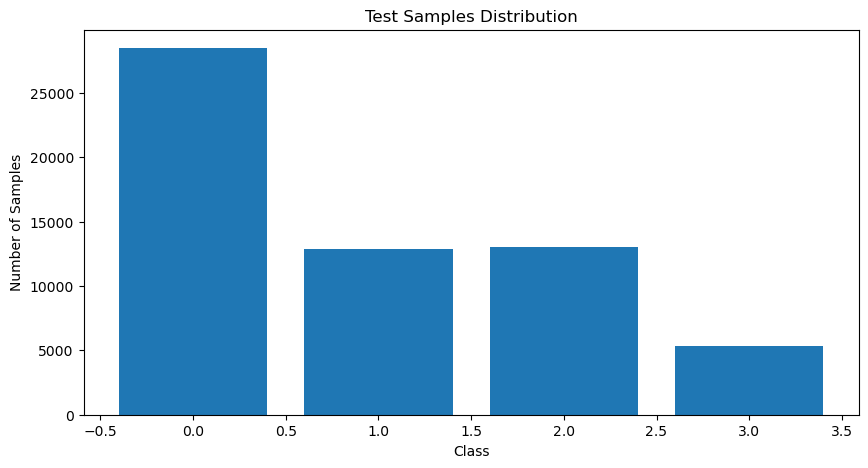

In [8]:
# import torch
# from torch.utils.data import DataLoader, random_split
# from collections import Counter
# import matplotlib.pyplot as plt

# import numpy as np
# from dataset import MonkeyMazeDataset, my_transforms as transforms
# def set_seed(seed):
#     import random
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)

    
# def print_test_distribution(test_loader):
#     label_counts = Counter()
#     with torch.no_grad():
#         for _, _, labels in test_loader:
#             label_counts.update(labels.cpu().numpy())
    
#     total_samples = sum(label_counts.values())
#     print("Test Samples Distribution:")
#     for label, count in label_counts.items():
#         print(f"Class {label}: {count} samples ({count/total_samples:.2%})")

#     plt.figure(figsize=(10, 5))
#     plt.bar(label_counts.keys(), label_counts.values())
#     plt.xlabel('Class')
#     plt.ylabel('Number of Samples')
#     plt.title('Test Samples Distribution')
#     plt.show()

# def main():
#     seed = 42
#     set_seed(seed)
#     image_dir = '/Users/xinglanzhao/Desktop/monkeymaze/MazeImage'
#     trajectory_dir = '/Users/xinglanzhao/Desktop/monkeymaze/Monkeytrajectory'

#     # Load the dataset
#     dataset = MonkeyMazeDataset(image_dir=image_dir, trajectory_dir=trajectory_dir, transform=transforms)
    
#     # Split dataset into training and testing
#     total_size = len(dataset)
#     test_ratio = 0.15
#     test_size = int(test_ratio * total_size)
#     train_val_size = total_size - test_size
#     _, test_dataset = random_split(dataset, [train_val_size, test_size])
#     test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

#     # Print test samples distribution
#     print_test_distribution(test_loader)

# if __name__ == "__main__":
#     main()
